<a href="https://colab.research.google.com/github/rub1nho10/ML-ADS-4NB-24/blob/main/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install pandas scikit-learn matplotlib seaborn joblib

         date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1  1873-03-08   England  Scotland           4           2   Friendly   London   
2  1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3  1875-03-06   England  Scotland           2           2   Friendly   London   
4  1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  
0  Scotland    False  
1   England    False  
2  Scotland    False  
3   England    False  
4  Scotland    False  
Times codificados: ['Abkhazia', 'Afghanistan', 'Albania', 'Alderney', 'Algeria']


<ipython-input-29-e7b40c9d5f80>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['home_score', 'away_score', 'year', 'month']] = scaler.fit_transform(X[['home_score', 'away_score', 'year', 'month']])


Acurácia média na validação cruzada: 1.00
Relatório de Classificação:
              precision    recall  f1-score   support

        Casa       1.00      1.00      1.00      4710
      Empate       1.00      1.00      1.00      2184
   Visitante       1.00      1.00      1.00      2690

    accuracy                           1.00      9584
   macro avg       1.00      1.00      1.00      9584
weighted avg       1.00      1.00      1.00      9584



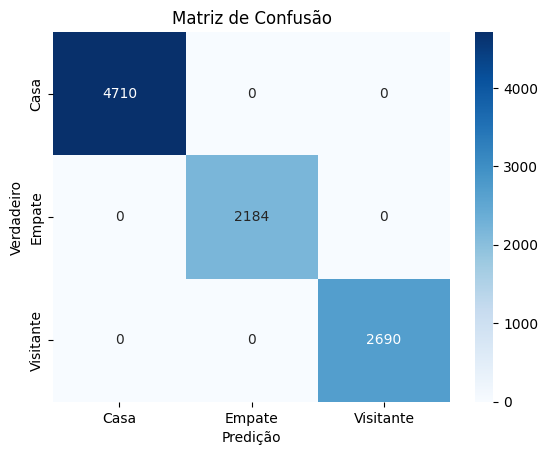

Previsão para o novo jogo: Empate


In [29]:
# Passo 1: Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Passo 2: Carregar o dataset
url = "https://raw.githubusercontent.com/martj42/international_results/master/results.csv"
data = pd.read_csv(url)

# Visualizar os primeiros registros
print(data.head())

# Passo 3: Pré-processamento
# Manter apenas colunas relevantes
data = data[['date', 'home_team', 'away_team', 'home_score', 'away_score']]

# Criar o alvo: Resultado do jogo (Casa/Empate/Visitante)
data['result'] = np.where(data['home_score'] > data['away_score'], 'Casa',
                          np.where(data['home_score'] < data['away_score'], 'Visitante', 'Empate'))

# Transformar as datas para ano e mês
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data.drop('date', axis=1, inplace=True)

# Codificar variáveis categóricas (equipes)
encoder = LabelEncoder()

# Concatenar as duas colunas de times para treinar o encoder
all_teams = pd.concat([data['home_team'], data['away_team']]).unique()
encoder.fit(all_teams)

# Transformar as colunas home_team e away_team
data['home_team'] = encoder.transform(data['home_team'])
data['away_team'] = encoder.transform(data['away_team'])

# Visualizar times codificados (primeiros 5)
print(f"Times codificados: {list(encoder.classes_[:5])}")

# Passo 4: Separar variáveis independentes (X) e alvo (y)
X = data[['home_team', 'away_team', 'home_score', 'away_score', 'year', 'month']]
y = data['result']

# Normalizar dados numéricos
scaler = StandardScaler()
X[['home_score', 'away_score', 'year', 'month']] = scaler.fit_transform(X[['home_score', 'away_score', 'year', 'month']])

# Passo 5: Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 6: Treinar o modelo com validação cruzada
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Acurácia média na validação cruzada: {np.mean(scores):.2f}")

# Treinar o modelo final
model.fit(X_train, y_train)

# Passo 7: Avaliar o modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Casa', 'Empate', 'Visitante'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Casa', 'Empate', 'Visitante'], yticklabels=['Casa', 'Empate', 'Visitante'])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

# Passo 8: Salvar o modelo para uso futuro
joblib.dump(model, '/content/modelo_futebol.pkl')
joblib.dump(encoder, '/content/encoder_times.pkl')
joblib.dump(scaler, '/content/scaler_dados.pkl')

# Passo 9: Usar o modelo para previsões futuras
# Verificar se os times estão presentes no encoder
def codificar_time(time, encoder):
    if time in encoder.classes_:
        return encoder.transform([time])[0]
    else:
        print(f"Erro: O time '{time}' não foi encontrado no encoder. Verifique se o nome está correto.")
        return None

# Exemplo de previsão
home_team = 'Brazil'  # Exemplo: Brasil como mandante
away_team = 'Argentina'  # Exemplo: Argentina como visitante

home_team_code = codificar_time(home_team, encoder)
away_team_code = codificar_time(away_team, encoder)

if home_team_code is not None and away_team_code is not None:
    novo_jogo = pd.DataFrame({
        'home_team': [home_team_code],
        'away_team': [away_team_code],
        'home_score': [0],  # Prever com placar inicial 0-0
        'away_score': [0],
        'year': [2024],
        'month': [12]
    })

    # Normalizar os dados
    novo_jogo[['home_score', 'away_score', 'year', 'month']] = scaler.transform(novo_jogo[['home_score', 'away_score', 'year', 'month']])

    # Fazer a previsão
    previsao = model.predict(novo_jogo)
    print(f"Previsão para o novo jogo: {previsao[0]}")
